# Limpieza de datos

## Carga de Datos

In [1]:
import pandas as pd

dataset_path = "../data/training.csv"
df_loaded = pd.read_csv(dataset_path)

## Procesamiento de datos

### Resumen del dataset

```pyhon
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                11696 non-null  object 
 1   Store ID            11696 non-null  object 
 2   Product ID          11696 non-null  object 
 3   Category            11696 non-null  object 
 4   Region              11696 non-null  object 
 5   Inventory Level     11696 non-null  int64  
 6   Units Sold          11696 non-null  int64  
 7   Units Ordered       11696 non-null  int64  
 8   Demand Forecast     11696 non-null  float64
 9   Price               11696 non-null  float64
 10  Discount            11696 non-null  int64  
 11  Weather Condition   11696 non-null  object 
 12  Holiday/Promotion   11696 non-null  int64  
 13  Competitor Pricing  11696 non-null  float64
 14  Seasonality         11696 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 1.3+ MB
```

### Conclusion

Como el dataset no presenta datos nulos, se procedera a la transformacion de estos para su posterior limpieza de outliers.
En el dataset se presentan 7 columnas del tipo objetos, una parte de estos se eliminaran al no ser relevantes para la limpieza y el resto se dumificaran

#### Columnas categoricas relevantes

- Seasonality
- Weather Condition
- Region
- Category


### Columnas a eliminar

- Product ID
- Store ID
- Date

### Procesamiento de Datos

- Dumificar
- Escalado Robusto
- Descomponer
- Comprimir
- Limpiar Outliers
- Normalizar (entre -1 y 1)

In [2]:
from sklearn.preprocessing import OneHotEncoder

# En esta celda dumificaremos el dataset

# Creamos una copia del dataset cargado para luego mutarlo
df_dummified = df_loaded.copy()


# Dropeamos columnas irrelevantes
drop_list = ["Date", "Store ID", "Product ID"]
df_dummified = df_dummified.drop(columns=drop_list)


# Dumificamos el dataset transformando literales en columnas binarias
# Seleccionar columnas categóricas
categorical_columns = ["Category", "Region", "Weather Condition", "Seasonality"]

# Inicializar el codificador
encoder = OneHotEncoder(sparse_output=False)

# Aplicar transformación
encoded_array = encoder.fit_transform(df_dummified[categorical_columns])

# Convertir a DataFrame con los nombres de nuevas columnas
encoded_columns = encoder.get_feature_names_out(categorical_columns)
df_encoded = pd.DataFrame(encoded_array, columns=encoded_columns)

# Concatenar con el DataFrame original, eliminando las columnas originales
df_dummified = df_dummified.drop(columns=categorical_columns).reset_index(drop=True)
df_dummified = pd.concat([df_dummified, df_encoded], axis=1)

# Verificamos dataset dumificado
df_dummified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Inventory Level           11696 non-null  int64  
 1   Units Sold                11696 non-null  int64  
 2   Units Ordered             11696 non-null  int64  
 3   Demand Forecast           11696 non-null  float64
 4   Price                     11696 non-null  float64
 5   Discount                  11696 non-null  int64  
 6   Holiday/Promotion         11696 non-null  int64  
 7   Competitor Pricing        11696 non-null  float64
 8   Category_Clothing         11696 non-null  float64
 9   Category_Electronics      11696 non-null  float64
 10  Category_Furniture        11696 non-null  float64
 11  Category_Groceries        11696 non-null  float64
 12  Category_Toys             11696 non-null  float64
 13  Region_East               11696 non-null  float64
 14  Region

In [3]:
from sklearn.preprocessing import RobustScaler

# En esta celda normalizamos el dataset dumificado
# creamos una copia para luego mutarla y conservar el original antes trabajado
df_scaled = df_dummified.copy()

# Creamos el escalador
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df_scaled)

# Convertimos a Dataframe el dataset escalado
df_scaled = pd.DataFrame(data_scaled, columns=df_scaled.columns)

# Visualizamos el minimo y maximo de las columnas escaladas
df_scaled.describe().loc[["min", "max"]]

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Category_Clothing,Category_Electronics,...,Region_South,Region_West,Weather Condition_Cloudy,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Autumn,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
min,-1.008811,-0.696774,-1.011236,-0.798668,-1.001221,-1.0,0.0,-1.104522,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.973568,2.490323,1.011236,2.553874,0.996559,1.0,1.0,1.109418,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
import numpy as np
from sklearn.decomposition import PCA

# En esta celda Descompondremos en componentes principales el dataset normalizado
pca = PCA()
pca.fit(df_scaled)

# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
mean_variance = explained_variance.mean() # Media de la varianza explicada

# Ponderamos la varianza media para incluir mas componentes principales
# y aumentar la varianza total explicada
weighted_mean_variance = mean_variance * 0.82

# Seleccionamos los Indices de componentes relevantes
selected_components = np.where(explained_variance > weighted_mean_variance)[0]

# Aplicar PCA con solo las componentes seleccionadas
pca_selected = PCA(n_components=len(selected_components))
compressed_data = pca_selected.fit_transform(df_scaled)

# Convertir a DataFrame
df_compressed = pd.DataFrame(compressed_data)

# Calculamos la varianza total explicada de las componentes seleccionadas
total_explained_variance = np.sum(explained_variance[selected_components]) * 100


print(f"Varianza Total Explicada: {total_explained_variance:.2f}%")
df_compressed.info()
df_compressed.describe().loc[["min", "max"]]

Varianza Total Explicada: 87.30%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       11696 non-null  float64
 1   1       11696 non-null  float64
 2   2       11696 non-null  float64
 3   3       11696 non-null  float64
 4   4       11696 non-null  float64
 5   5       11696 non-null  float64
 6   6       11696 non-null  float64
 7   7       11696 non-null  float64
 8   8       11696 non-null  float64
 9   9       11696 non-null  float64
 10  10      11696 non-null  float64
 11  11      11696 non-null  float64
 12  12      11696 non-null  float64
 13  13      11696 non-null  float64
 14  14      11696 non-null  float64
dtypes: float64(15)
memory usage: 1.3 MB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
min,-1.614499,-1.549255,-1.102250,-1.097807,-1.042205,-1.138483,-1.145875,-1.021925,-1.094200,-1.270129,-0.873670,-1.295408,-1.042831,-1.130071,-0.506791
max,3.467584,1.544817,1.075005,1.081896,1.394923,1.480363,1.311102,1.302927,1.378623,1.323888,1.265482,1.213946,1.306214,1.465972,1.098097


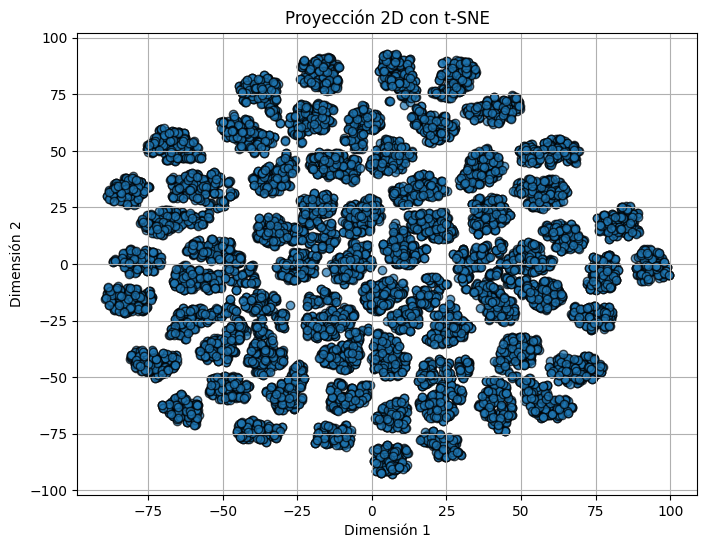

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# AVISO: Esta celda tiene un alto coste computacional para renderizar el grafico
# Aplicar t-SNE para reducir a 2 dimensiones
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
df_2d = tsne.fit_transform(df_compressed)

# Graficar los puntos en 2D
plt.figure(figsize=(8, 6))
plt.scatter(df_2d[:, 0], df_2d[:, 1], alpha=0.7, edgecolors="k")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.title("Proyección 2D con t-SNE")
plt.grid(True)
plt.show()


In [ ]:
# TODO @Seba1996c: Limpiar Outliers y guardar indices de las filas eliminadas
# NOTE Rango intercuartílico (IQR), Isolation Forest o DBSCAN

In [ ]:
# TODO @Seba1996c: Normalizar entre -1 y 1

In [ ]:
# TODO @Seba1996c: Cambiar los indices del Data Frame final por la columna Date

# NOTE: Filtar los indices eliminados antes de agregar las columnas

In [ ]:
# TODO @Seba1996c: Guardar DataFrame final como archivo .csv

In [ ]:
# TODO @Seba1996c: Guardar todos los encoders generados y crear una pipeline